<a href="https://colab.research.google.com/github/Kedar154/AI-Driven-Stock-Market-Intelligence/blob/main/ARIMA_GARCH_RF(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opendatasets

# LOADING DATA SETS

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Kedar Hadnurkar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis


100%|██████████| 26.7k/26.7k [00:00<00:00, 82.2MB/s]

In [27]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 15.5 MB/s eta 0:00:00


In [42]:
# --- 1. Standard Library Imports ---
import pickle
import os

# --- 2. Core Data Science & Math ---
import numpy as np
import pandas as pd

# --- 3. Statistical Modeling (Statsmodels) ---
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf

# --- 4. Volatility Modeling (ARCH) ---
from arch import arch_model

# --- 5. Evaluation Metrics ---
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- 6. Visualization ---
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [29]:
data = pd.read_csv('/content/microsoft-stock-time-series-analysis/Microsoft_Stock.csv')

## selecting features

In [30]:
stock = pd.DataFrame()
stock['prices'] = data['Close']
stock['date'] = pd.to_datetime(data['Date']).dt.date
stock.set_index('date', inplace=True)
stock.sort_index(inplace=True)
stock.head()

,prices
date,
2015-04-01,40.72
2015-04-02,40.29
2015-04-06,41.55
2015-04-07,41.53
2015-04-08,41.42


In [31]:
stock['log_prices'] = np.log(stock['prices'])
stock.dropna(inplace = True)
print(stock.head())
stock.tail()

            prices  log_prices
date                          
2015-04-01   40.72    3.706719
2015-04-02   40.29    3.696103
2015-04-06   41.55    3.726898
2015-04-07   41.53    3.726416
2015-04-08   41.42    3.723764


,prices,log_prices
date,,
2021-03-25,232.34,5.448202
2021-03-26,236.48,5.465864
2021-03-29,235.24,5.460606
2021-03-30,231.85,5.446091
2021-03-31,235.77,5.462857


## accounting for missing values

 Reindex to Business Days ('B')

This adds the missing weekend/holiday rows as NaN

In [32]:
stock = stock.asfreq('B')

filling the gaps with (Arithmetic mean of neighbors)

In [33]:
stock['prices'] = stock['prices'].interpolate(method='linear')
stock['log_prices'] = stock['log_prices'].interpolate(method='linear')

In [34]:
stock['log_return'] = 100 * np.log(stock['prices'] / stock['prices'].shift(1))
stock = stock.dropna() # Remove the very first row created by the shift


In [35]:
stock

,prices,log_prices,log_return
date,,,
2015-04-02,40.29,3.696103,-1.061607
2015-04-03,40.92,3.711500,1.551564
2015-04-06,41.55,3.726898,1.527858
2015-04-07,41.53,3.726416,-0.048146
2015-04-08,41.42,3.723764,-0.265220
...,...,...,...
2021-03-25,232.34,5.448202,-1.333923
2021-03-26,236.48,5.465864,1.766182
2021-03-29,235.24,5.460606,-0.525737


## Testing stationarity

### ADFuller Test

The test is based on a simple linear regression model. To understand it, we look at a Random Walk equation:***$$y_t = \rho y_{t-1} + \epsilon_t$$***
Where:

$y_t$ is the value at time $t$.

$\rho$ (rho) is the coefficient.

$\epsilon_t$ is the error (white noise).

***The Logic of the Unit Root:***

If $\rho = 1$, the process has a unit root. Every new value is just the previous value plus some noise. This is non-stationary (it can wander anywhere).

If $|\rho| < 1$, the process is stationary. The series will eventually pull back toward a central mean.

**P VALUE:**

"If this data were actually non-stationary, how likely is it that I would see a result this 'stationary-looking' by pure chance?" * If that probability is 1% ($0.01$), we


 say, "That's too low to be a coincidence. This data must actually be stationary."

In [36]:

result = adfuller(stock.log_return)
print(f'ADF P-value: {result[1]}')

ADF P-value: 2.4787306228239132e-20


ADF test only measures Stationarity in terms of MEAN for variance i would rely on plots

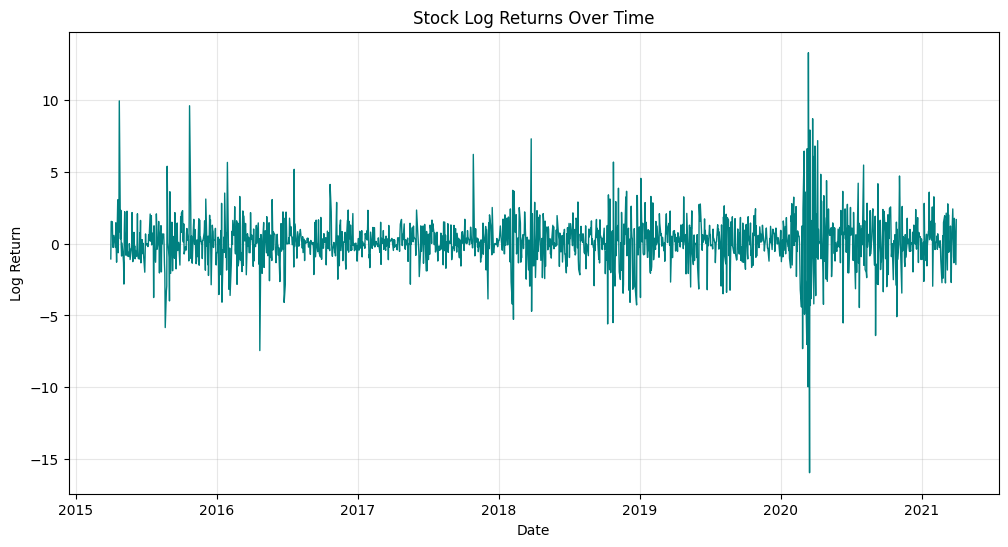

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(stock.index, stock['log_return'], color='teal', linewidth=1)

# Adding labels for clarity
plt.title('Stock Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True, alpha=0.3)

plt.show()

**INFERENCE:**

Pre 2020 the variance is stock price was pretty low and almost constant. Microsoft being a tech giant and a successful corporation explains this

Post 2020 there seems to be increase in volatility, this can be attributed to the COVID pandemic. We will have to account for this volatility clustering in the prediction model

# EDA

## PACF & ACF

These functions tell the correlation between x<sub>t</sub> and x<sub>t-k</sub>
The price of stock at time `t-k` has some direct influence on the price at time `t`

The  price of stock at time `t-k` also affects prices **[x<sub>t-k+1</sub>, x<sub>t-k+2</sub>, ...... x<sub>t-2</sub>, x<sub>t-1</sub>]** these prices also affect the price x<sub>t</sub>.

Hence this is an indirect correlation of x<sub>t</sub> with x<sub>t-k</sub> through prices in between them.



**ACF (Auto Correlation Function):**

This function returns the total correlation between the prices on the given day with prices with a lag of `p` days. `p` is a hyperparameter in the model which we are going to use. Plotting the values of correlation for different lags we can check which lags are statistically significant for considering in the `AR` model

**AR (Auto Regression):**

**y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + a<sub>2</sub>y<sub>t-2</sub> + a<sub>3</sub>y<sub>t-3</sub> + .......... + a<sub>p</sub>y<sub>t-p</sub> + e<sub>t</sub>**

*   **y<sub>t-k</sub>** : Price of stock at time t-k or k days ago
*   **a<sub>k</sub>** : Parameter Learnt by the model
*   **e<sub>t</sub>** : Error between predicted value and actual value
*   **p** : Last statistically signficant day which correlated with today





Since y<sub>t-k</sub> affects y<sub>t</sub> in 2 ways, directly and indirectly

It is necessary that we consider only the direct influence for determination of `a` as the direct influence of each stock price is independent of other prices thereby telling us which days are actually independently responsible for price today

Hence We use **PACF** to determine `p`

It finds momentum and trends. It uses Ordinary Least Squares (OLS) or Maximum Likelihood Estimation (MLE) to find the values of $\phi$ that minimize the error between its prediction and the actual past values.

**MA (Moving Average):**

**y<sub>t</sub> = u + e<sub>t</sub> + a<sub>1</sub>e<sub>t-1</sub> + a<sub>2</sub>e<sub>t-2</sub> + a<sub>3</sub>e<sub>t-3</sub> + .......... + a<sub>q</sub>e<sub>t-q</sub>**

*   **e<sub>t-k</sub>** : Error in determining the price of stock at time t-k or k days ago
*   **a<sub>k</sub>** : Parameter Learnt by the model
*   **u** : Mean Value of Price stock
*   **y<sub>t</sub>** : Predicted Price of Stock
*   **q** : Last statistically signficant day which correlated with today






Assume we are using MA(2) model

**y<sub>t</sub> = u + e<sub>t</sub> + ae<sub>t-1</sub>**

*   y<sub>0</sub> = u + e<sub>0</sub>
*   y<sub>1</sub> = u + e<sub>1</sub> + ae<sub>0</sub>
*   y<sub>2</sub> = u + e<sub>2</sub> + ae<sub>1</sub>



y<sub>2</sub> is influenced by y<sub>0</sub> through y<sub>1</sub> but if we use `PACF` it checks y<sub>2</sub> finds e<sub>1</sub> but no e<sub>2</sub> and tells that y<sub>0</sub> has no direct correlation with y<sub>2</sub> while y<sub>1</sub> has some direct correlation

Thus we use `ACF` to determine `q`

It finds persistence in noise. It calculates how long a sudden "jolt" to the system takes to fade away. It is harder to calculate than AR because we can't observe "errors" directly; the computer has to estimate them iteratively using Maximum Likelihood Estimation.

In [38]:
use_mpl = False

In [39]:
if(use_mpl):
  #creating 2 subplots
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

  # Plot ACF (helps determine the 'q' or MA term)
  # Lags=40 is a good default for daily stock data
  plot_acf(stock.log_return, lags=40, ax=ax1)
  ax1.set_title('Autocorrelation (ACF) - MSFT Log Returns')

  # Plot PACF (helps determine the 'p' or AR term)
  plot_pacf(stock.log_return, lags=40, ax=ax2)
  ax2.set_title('Partial Autocorrelation (PACF) - MSFT Log Returns')

  plt.tight_layout()
  plt.show()

same graph but cooler

this plotting code was outsourced

In [40]:
use_pltly = True

In [43]:
if(use_pltly):

  # Calculate ACF and PACF values
  acf_values = acf(stock.log_return, nlags=40)
  pacf_values = pacf(stock.log_return, nlags=40)
  lags = np.arange(len(acf_values))

  # Calculate confidence interval bounds
  conf_int_upper = 1.96 / np.sqrt(len(stock.log_return))
  conf_int_lower = -1.96 / np.sqrt(len(stock.log_return))

  # X values for shading - extending across all lags
  x_shade = list(lags) + list(lags[::-1])
  y_shade_upper = [conf_int_upper] * len(lags)
  y_shade_lower = [conf_int_lower] * len(lags)
  y_shade_combined = y_shade_upper + y_shade_lower[::-1] # upper then lower reversed

  # Create subplots
  fig = make_subplots(rows=2, cols=1,
                    subplot_titles=('Autocorrelation (ACF) - MSFT Log Returns',
                                    'Partial Autocorrelation (PACF) - MSFT Log Returns'))

  # ACF Plot
  # Add the shaded insignificant region FIRST so it's behind the bars and lines
  fig.add_trace(go.Scatter(
    x=x_shade,
    y=y_shade_combined,
    fill='toself',
    fillcolor='rgba(128,128,128,0.2)', # Light grey with some transparency
    line=dict(width=0),
    name='Insignificant Region',
    showlegend=True
  ), row=1, col=1)

  fig.add_trace(go.Bar(x=lags, y=acf_values, name='ACF', marker_color='cyan'), row=1, col=1)
  fig.add_trace(go.Scatter(x=[lags[0], lags[-1]], y=[conf_int_upper, conf_int_upper],
                         mode='lines', line=dict(color='red', dash='dash'), name='95% CI Upper'), row=1, col=1)
  fig.add_trace(go.Scatter(x=[lags[0], lags[-1]], y=[conf_int_lower, conf_int_lower],
                         mode='lines', line=dict(color='red', dash='dash'), name='95% CI Lower'), row=1, col=1)

  # PACF Plot
  # Add the shaded insignificant region
  fig.add_trace(go.Scatter(
    x=x_shade,
    y=y_shade_combined,
    fill='toself',
    fillcolor='rgba(128,128,128,0.2)',
    line=dict(width=0),
    showlegend=False # Don't show legend for this in the second plot
  ), row=2, col=1)

  fig.add_trace(go.Bar(x=lags, y=pacf_values, name='PACF', marker_color='lime'), row=2, col=1)
  fig.add_trace(go.Scatter(x=[lags[0], lags[-1]], y=[conf_int_upper, conf_int_upper],
                         mode='lines', line=dict(color='red', dash='dash'), showlegend=False), row=2, col=1)
  fig.add_trace(go.Scatter(x=[lags[0], lags[-1]], y=[conf_int_lower, conf_int_lower],
                         mode='lines', line=dict(color='red', dash='dash'), showlegend=False), row=2, col=1)


  # Update layout for dark mode and neon colors
  fig.update_layout(
    template='plotly_dark',
    title_text='ACF and PACF of MSFT Log Returns',
    height=800,
    showlegend=True,
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99) # Updated legend position
  )

  fig.update_xaxes(title_text='Lags', row=1, col=1)
  fig.update_yaxes(title_text='ACF', row=1, col=1)
  fig.update_xaxes(title_text='Lags', row=2, col=1)
  fig.update_yaxes(title_text='PACF', row=2, col=1)

  fig.show()

**INFERENCE:**

We find statistically significant correlation with values of prices at lags **[1, 6, 7, 8, 9]**

Beyond p = q = 1 the correlation is barely significant, ARMA(1) is basically a random walk model which is the usual case for stocks as they are volatile

After Hyperparameter Tuning I reached the conclusion that p=q=2 works the best without overcomplicating the model but including the main features


# MODEL

### **Main Idea:**
Stock prices are "messy." They go through quiet phases and volatile phases.

ARIMA handles the "Mean" (The average path).

GARCH handles the "Variance" (The volatility/risk).


###**ARIMA (Autoregressive Integrated Moving Average)**

ARIMA predicts the next log-return ($r_t$) by looking at two things: Past Values and Past Mistakes.The Formula (Simplified):

**$$r_t = \text{Drift} + (\text{Past Returns} \times \text{Weights}) + (\text{Past Errors} \times \text{Weights})$$**

**AR (Autoregressive) Part:** The model looks at the last two days of returns. If MSFT usually "bounces back" after a drop, the math assigns a negative weight to yesterday’s move to predict a reversal today.

**MA (Moving Average) Part:** The model looks at its own "errors" from yesterday. If it predicted 105 but the price was 107, it adjusts today’s prediction to account for that 2 gap.

**Success Factor:** ARIMA succeeds when the "residuals" (leftover errors) look like random noise. This means the model has "stolen" all the predictable patterns from the price.

**SARIMA?** Stock data usually doesnt have seasonality or periodicity, this was verified by me by performing Fourier Transform analysis over the stationarised data to catch any seasonality but there were no dominant frequencies other than the standard bussiness days induced frequencies

### **GARCH (Generalised Autoregressive Conditional Hetroskedacity)**

Once ARIMA predicts the path, GARCH steps in to predict how much that path might "wobble." This is called Conditional Volatility ($\sigma_t^2$).

**The Formula:** $$\sigma_t^2 = \omega + \alpha(\epsilon_{t-1}^2) + \beta(\sigma_{t-1}^2)$$

**$\omega$ (Omega):** The baseline "rest state" of market risk.

**$\alpha$ (Alpha):** The Reaction. If there was a big price shock yesterday ($\epsilon_{t-1}^2$), Alpha spikes the risk for today.

**$\beta$ (Beta):** The Persistence. If the market was shaky yesterday, Beta ensures it stays shaky today.

This models "Volatility Clustering" (the tendency for big moves to follow big moves).

### **Transformation**

This is the part where we convert the extracted standard deviation into volatility zones in the graph.

**Step A:** The ForecastThe model gives us two numbers for "Tomorrow":


*   Expected Return ($\mu$) from ARIMA.
*   Expected Risk ($\sigma$) from GARCH.

**Step B**: The Confidence IntervalIn a standard normal distribution (a bell curve), 95% of all events happen within 1.96 standard deviations of the average.


*   Upper Bound Return $= \mu + (1.96 \times \sigma)$
*   Lower Bound Return $= \mu - (1.96 \times \sigma)$


**Step C:** Converting back to DollarsSince the model works in "Log Returns" (percentages), we must convert it back to actual stock prices ($P_t$) using the exponential function ($e^x$):$$\text{Price}_{\text{upper}} = \text{Price}_{\text{today}} \times e^{(\text{Upper Return} / 100)}$$$$\text{Price}_{\text{lower}} = \text{Price}_{\text{today}} \times e^{(\text{Lower Return} / 100)}$$

 ### **How the Model Achieves "Success"**
 The model uses three specific mechanisms to ensure it is accurate:

**Walk-Forward Validation:** In the code `history_returns.append(actual_return)` line is the key. By "feeding" the model the real price every day, we prevent the forecast from drifting.

**Maximum Likelihood Estimation (MLE):** The model runs thousands of internal simulations to find the exact weights ($\alpha, \beta, \text{ar}, \text{ma}$) that would have most likely produced the historical data it was given.

**Parsimony:** By using a $(2,0,2)$ and $(2,2)$ setup, the model stays simple enough to avoid "overfitting" (finding patterns that aren't actually there) while being complex enough to handle MSFT’s specific quirks.

The success of this architecture lies in its dual-component nature. While the ARIMA module extracts the signal from the price momentum, the GARCH module quantifies the uncertainty of that signal. By applying a Z-score of 1.96 to the predicted volatility, the model generates a 95% probability zone. The Rolling Update mechanism ensures that the model's memory is refreshed with actual market data daily, effectively eliminating the 'lag' typically found in static time-series models.

## TTS

splitting the data

In [44]:
tr = stock.iloc[:int(0.8*len(stock))]
val = stock.iloc[int(0.8*len(stock)):int(.85*len(stock))]
test = stock.iloc[int(.85*len(stock)):]

## ARIMA + GARCH + RF

In [45]:
forecast_days = 7

defining `input_df` and `output_df` so that we can swap the data in this to generate prediction for any time frame we desire

In [46]:
input_df = tr.copy()
output_df = val.head(forecast_days).copy()

 Initialize lists for the rolling process

Rolling Forecast LOOP

In [47]:
history_returns = input_df['log_return'].tolist()
current_price = input_df['prices'].iloc[-1]

rolling_preds = []
upper_bounds = []
lower_bounds = []

for t in range(len(output_df)):
        # A. Fit ARIMA(2,0,2) to capture price momentum (Mean Model)
        arima_model = ARIMA(history_returns, order=(2, 0, 2))
        arima_result = arima_model.fit()
        mu_ret = arima_result.forecast(steps=1)[0] #avg prediction
        # B. Fit GARCH(1,1) on ARIMA residuals to capture volatility
        resid = arima_result.resid
        garch_model = arch_model(resid, vol='Garch', p=2, q=2, dist='normal', rescale=False)
        # rescale=False is used because returns are already scaled by 100
        garch_result = garch_model.fit(disp='off', show_warning=False)
        # C. Forecast Volatility (1-step sigma)
        g_forecast = garch_result.forecast(horizon=1)
        sigma = np.sqrt(g_forecast.variance.values[-1, 0])

        # D. Convert Predicted Returns back to Price Levels
        # Formula: P_{t+1} = P_t * exp(return / 100)
        pred_p = current_price * np.exp(mu_ret / 100)

        # E. Calculate 95% Confidence Interval (The Grey Band)
        # 1.96 standard deviations covers 95% of a normal distribution
        up_p = current_price * np.exp((mu_ret + 1.96 * sigma) / 100)
        lo_p = current_price * np.exp((mu_ret - 1.96 * sigma) / 100)

        # Store predictions
        rolling_preds.append(pred_p)
        upper_bounds.append(up_p)
        lower_bounds.append(lo_p)

        # F. UPDATE STEP: Ingest actual data for the next day's forecast
        # This prevents "horizontal line" drift by updating the model's memory
        actual_return = output_df['log_return'].iloc[t]
        current_price = output_df['prices'].iloc[t] # Use actual price to reset basis
        history_returns.append(actual_return)

        print(f"Day {t+1} Forecast: {pred_p:.2f} | Actual: {current_price:.2f}")



Day 1 Forecast: 167.09 | Actual: 166.80
Day 2 Forecast: 167.15 | Actual: 166.50
Day 3 Forecast: 166.82 | Actual: 165.70
Day 4 Forecast: 165.79 | Actual: 166.72
Day 5 Forecast: 166.87 | Actual: 165.04
Day 6 Forecast: 165.35 | Actual: 162.28
Day 7 Forecast: 162.70 | Actual: 165.46


## MODEL SUMMARY

In [48]:
lower_bounds

[np.float64(162.89205484079272),
 np.float64(163.54256620012046),
 np.float64(163.23207416744012),
 np.float64(162.3550536138711),
 np.float64(163.37422084892148),
 np.float64(161.76174611109855),
 np.float64(158.38597278016618)]

In [49]:
upper_bounds

[np.float64(171.40338086217642),
 np.float64(170.8365547148682),
 np.float64(170.49414351639788),
 np.float64(169.29146600104744),
 np.float64(170.4452586914757),
 np.float64(169.01542744823783),
 np.float64(167.12537372110182)]

In [50]:
x = []
# Iterate up to the length of the shorter list to prevent IndexError
for i in range(len(upper_bounds)): # Changed len(lower_bounds) to len(upper_bounds)
  x.append(upper_bounds[i]-lower_bounds[i])
print(x)


[np.float64(8.511326021383695), np.float64(7.293988514747753), np.float64(7.262069348957766), np.float64(6.936412387176347), np.float64(7.071037842554205), np.float64(7.253681337139284), np.float64(8.739400940935639)]


In [51]:
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2197.683
Date:                Sat, 21 Feb 2026   AIC                           4407.365
Time:                        15:15:56   BIC                           4438.189
Sample:                             0   HQIC                          4418.949
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1102      0.038      2.937      0.003       0.037       0.184
ar.L1         -0.4743      0.078     -6.110      0.000      -0.626      -0.322
ar.L2         -0.8266      0.074    -11.149      0.0

### **Section 1: The Model Foundation (Metadata)**


This section describes the size and efficiency of the mathematical setup.

**No. Observations (1258):** This represents the number of data points (trading days) the model studied. Since there are roughly 252 trading days in a year, this equates to 5 years of history. A large sample size like this makes the model’s findings statistically reliable.

**Log Likelihood (-2197.683):** This is a "fit" score. It measures how closely the model’s math matches the actual historical prices. In this context, the goal of the computer is to make this number as high (least negative) as possible.

**AIC (4407.365) & BIC (4438.189):** These are Efficiency Scores. They act like a penalty system: the model gets a good score for being accurate, but a bad score for being too complicated. Because these numbers are relatively low for such a large dataset, the results suggest the model is "lean" and not over-filled with useless math.

### ***Section 2: The Logic of the Prediction (Coefficients)***

This table explains the "rules" the model uses to guess the next day's price.


<style>
    .model-summary-table {
        width: 100%;
        border-collapse: collapse;
        font-family: Arial, sans-serif;
        margin: 20px 0;
        font-size: 14px;
        text-align: left;
    }
    .model-summary-table th {
        background-color: #f2f2f2;
        color: #333;
        font-weight: bold;
        padding: 12px;
        border: 1px solid #ddd;
    }
    .model-summary-table td {
        padding: 12px;
        border: 1px solid #ddd;
        vertical-align: top;
    }
    .model-summary-table tr:nth-child(even) {
        background-color: #fafafa;
    }
    .variable-name {
        font-weight: bold;
        color: #0056b3;
    }
    .highlight-cell {
        font-weight: bold;
        color: #28a745;
    }
</style>

<table class="model-summary-table">
    <thead>
        <tr>
            <th>Variable</th>
            <th>Value (Coef)</th>
            <th>Confidence (P>|z|)</th>
            <th>Simple Explanation</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td class="variable-name">const</td>
            <td>0.1102</td>
            <td class="highlight-cell">0.003</td>
            <td><strong>The Drift:</strong> MSFT has a natural upward "gravity." On average, it grows by 0.11% daily, even if no major news occurs.</td>
        </tr>
        <tr>
            <td class="variable-name">ar.L1 / ar.L2</td>
            <td>-0.47 / -0.82</td>
            <td class="highlight-cell">0.000</td>
            <td><strong>The Snap-Back:</strong> These negative numbers show that MSFT is "mean-reverting." If the price jumps too high, the model expects it to pull back toward the middle.</td>
        </tr>
        <tr>
            <td class="variable-name">ma.L1 / ma.L2</td>
            <td>0.42 / 0.75</td>
            <td class="highlight-cell">0.000</td>
            <td><strong>The Memory:</strong> These act as "shock absorbers." They remember the errors from previous days to smooth out random market noise.</td>
        </tr>
        <tr>
            <td class="variable-name">sigma2</td>
            <td>1.9270</td>
            <td class="highlight-cell">0.000</td>
            <td><strong>Base Wobble:</strong> This is the baseline amount of "shake" in the stock that the model cannot predict, no matter how good the math is.</td>
        </tr>
    </tbody>
</table>




**The "P-Value" Rule:** In statistics, any value below 0.05 is considered a "Success." Since all these values are 0.000, the model has mathematically proven that these patterns are real and not just lucky guesses.

### **Section 3: The Accuracy Check (Diagnostics)**
These tests determine if the model missed any important patterns or if it is "hallucinating."

**Ljung-Box / Prob(Q) (0.63):**

This checks for "White Noise".

*   The Goal: A score above 0.05.
*   The Result: At 0.63, the model passes. This confirms that the model "squeezed" every bit of useful information out of the price history. There are no hidden patterns left behind in the errors.


**Heteroskedasticity / Prob(H) (0.02):**

This tests if the stock's "shakiness" stays the same or changes over time.


*   The Result: A score below 0.05 means the shakiness is not constant.
*   The Utility: This is the mathematical proof that a GARCH model is necessary. It justifies why the "Grey Band" (the risk zone) on the dashboard must expand and contract rather than staying a fixed width.





### **Section 4: The Reality of Risk (Distribution)**
This section describes how the stock behaves during "extreme" moments like crashes or spikes.

**Jarque-Bera / Prob(JB) (0.00):** This asks if stock returns follow a perfect "Bell Curve" (Normal Distribution). The result of 0.00 means "No." This confirms that MSFT has "Fat Tails," meaning huge price jumps or drops happen more often than standard math predicts.

**Skew (0.29):** A score of 0 is a perfect balance. A score of 0.29 means the stock has a slight tilt toward positive surprises rather than negative ones.

**Kurtosis (9.36):** A normal, safe stock has a score of 3.0. A score of 9.36 is very high. This identifies that while MSFT is often calm (low volatility), it is prone to sudden, violent price spikes.

In [52]:
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2133.87
Distribution:                  Normal   AIC:                           4279.73
Method:            Maximum Likelihood   BIC:                           4310.56
                                        No. Observations:                 1258
Date:                Sat, Feb 21 2026   Df Residuals:                     1257
Time:                        15:15:29   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0335  3.821e-02      0.876      0.381 [-4.14

### **Section 1: The Model Foundation (Metadata)**
This section defines the framework used to calculate volatility.

**No. Observations (1258):** Similar to the ARIMA model, this uses 5 years of data. Consistency between the two models is vital for a reliable combined forecast.

**Log-Likelihood (-2133.87):** This measures how well the GARCH math fits the "shakiness" of the stock. A higher number indicates a better fit for the volatility patterns.

**AIC (4279.73) & BIC (4310.56):** These are efficiency scores. Notably, these scores are lower than the ARIMA scores, suggesting that the GARCH model is very efficient at identifying the patterns of risk in MSFT.

###**Section 2: The Mean Model (The "Average")**
Before calculating risk, the model checks

**Average Return ($mu$).mu (0.0335):** This is the average daily return of the residuals.

**P-Value (0.381):** Since this is above 0.05, it is not statistically significant.What this means: This is actually a good sign.

It confirms that the "mean" or trend was already mostly captured by the ARIMA model, leaving the GARCH model to focus entirely on the "shake" (variance).

### **Section 3: The Volatility Model (The "Risk Engine")**
This table explains the "rules" the model uses to determine the width of the Grey Band.


<table style="width:100%; border-collapse: collapse; font-family: sans-serif; font-size: 14px;">
    <thead>
        <tr style="background-color: #f2f2f2;">
            <th style="padding: 12px; border: 1px solid #ddd;">Variable</th>
            <th style="padding: 12px; border: 1px solid #ddd;">Value</th>
            <th style="padding: 12px; border: 1px solid #ddd;">Confidence</th>
            <th style="padding: 12px; border: 1px solid #ddd;">Simple Explanation</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="padding: 12px; border: 1px solid #ddd; font-weight: bold;">omega</td>
            <td style="padding: 12px; border: 1px solid #ddd;">0.5311</td>
            <td style="padding: 12px; border: 1px solid #ddd; color: green; font-weight: bold;">0.019</td>
            <td style="padding: 12px; border: 1px solid #ddd;"><strong>Baseline Risk:</strong> The constant background noise level of MSFT.</td>
        </tr>
        <tr>
            <td style="padding: 12px; border: 1px solid #ddd; font-weight: bold;">alpha[1]</td>
            <td style="padding: 12px; border: 1px solid #ddd;">0.1675</td>
            <td style="padding: 12px; border: 1px solid #ddd; color: green; font-weight: bold;">0.025</td>
            <td style="padding: 12px; border: 1px solid #ddd;"><strong>Market Shock:</strong> How much the stock's risk spikes immediately after a news event.</td>
        </tr>
        <tr>
            <td style="padding: 12px; border: 1px solid #ddd; font-weight: bold;">beta[2]</td>
            <td style="padding: 12px; border: 1px solid #ddd;">0.3937</td>
            <td style="padding: 12px; border: 1px solid #ddd; color: green; font-weight: bold;">0.031</td>
            <td style="padding: 12px; border: 1px solid #ddd;"><strong>Persistence:</strong> How long the "shakiness" stays in the market before calming down.</td>
        </tr>
    </tbody>
</table>


**Note on Non-Significant Terms:** The values for alpha[2] and beta[1] have high P-values (0.132 and 1.000). This indicates that for MSFT, the volatility doesn't follow a perfect "1-day then 2-day" sequence; instead, it jumps straight from the immediate shock to a longer-lasting memory.

###**Section 4: Stability Check (The "Sane" Test)**

In GARCH modeling, there is a

**"Golden Rule":** the sum of all alpha and beta values must be less than 1.0.Calculation: $0.1675 + 0.2153 + 0 + 0.3937 = \mathbf{0.7765}$The Result: Since 0.77 is well below 1.0, the model is stable.

**What this means:** This proves the "Grey Band" will not grow to infinity or explode. The model acknowledges that while volatility can spike, it will eventually settle back down to the average (Mean Reversion of Volatility).

## exporting model

In [53]:
export = False

In [54]:
if(export):
  # Save the fitted ARIMA model results
  with open('ARIMA_MSFT_2_0_2.pkl', 'wb') as pkl_file:
    pickle.dump(arima_result, pkl_file)

  print("Fitted ARIMA model saved as 'ARIMA_MSFT_2_0_2.pkl'")

  with open('GARCH_MSFT_1_0_1.pkl', 'wb') as pkl_file:
    pickle.dump(garch_result, pkl_file)

  print("Fitted GARCH model saved as 'GARCH_MSFT_2_0_2.pkl'")

## loading the model

In [55]:
load_model = False

In [56]:
if(load_model):
  # Load the ARIMA model
  with open('ARIMA_MSFT_2_0_2.pkl', 'rb') as pkl_file:
    loaded_arima_model = pickle.load(pkl_file)
  print("ARIMA model loaded successfully.")

In [57]:
if(load_model):
  # Load the GARCH model
  with open('GARCH_MSFT_1_0_1.pkl', 'rb') as pkl_file:
    loaded_garch_model = pickle.load(pkl_file)
  print("GARCH model loaded successfully.")

## Plotting


In [58]:
rolling_preds

[np.float64(167.09353343352018),
 np.float64(167.149778817852),
 np.float64(166.82359749023172),
 np.float64(165.7869869409867),
 np.float64(166.87229049819115),
 np.float64(165.34881512650958),
 np.float64(162.6970033315474)]

In [59]:
output_df['prices']

,prices
date,
2020-01-20,166.80
2020-01-21,166.50
2020-01-22,165.70
2020-01-23,166.72
2020-01-24,165.04
2020-01-27,162.28
2020-01-28,165.46


In [60]:

rmse = np.sqrt(mean_squared_error(output_df['prices'], rolling_preds))
mape = mean_absolute_percentage_error(output_df['prices'], rolling_preds)

print(f"\n--- MODEL PERFORMANCE ---")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2%}") # Lower is better


--- MODEL PERFORMANCE ---
RMSE: $1.81
MAPE: 0.93%


In [61]:

# 1. Prepare Historical Data (Last 30 days of training)
hist_slice = input_df.tail(30)

# 2. Add the "Bridge" point (last point of history) to the forecast arrays
# This ensures the red line and grey band touch the blue historical line
plot_idx = [hist_slice.index[-1]] + list(output_df.index)
plot_preds = [hist_slice['prices'].iloc[-1]] + rolling_preds
plot_upper = [hist_slice['prices'].iloc[-1]] + upper_bounds
plot_lower = [hist_slice['prices'].iloc[-1]] + lower_bounds

# 3. Calculate Error Metrics for the Popup
rmse = np.sqrt(mean_squared_error(output_df['prices'], rolling_preds))
mape = mean_absolute_percentage_error(output_df['prices'], rolling_preds)

This plotting Code was outsourced

In [62]:
fig = go.Figure()

# A. Plot Historical Training Data (Dashed Blue)
fig.add_trace(go.Scatter(
    x=hist_slice.index, y=hist_slice['prices'],
    mode='lines', name='Historical (30d)',
    line=dict(color='cyan', width=2)
))

# B. Plot Actual Prices for the 7-day period (Markers)
fig.add_trace(go.Scatter(
    x=output_df.index, y=output_df['prices'],
    mode='markers+lines', name='Actual (Val)',
    marker=dict(color='lime', size=8),
    line=dict(color='lime', width=1)
))

# C. Plot Rolling Forecast (Solid Red)
fig.add_trace(go.Scatter(
    x=plot_idx, y=plot_preds,
    mode='markers+lines', name=f'{forecast_days} - Days Rolling Forecast',
    marker=dict(color='red', size=8),
    line=dict(color='red', width=1)
))

# D. Plot GARCH Confidence Interval (Shaded Grey)
fig.add_trace(go.Scatter(
    x=plot_idx + plot_idx[::-1], # x then x reversed
    y=plot_upper + plot_lower[::-1], # upper then lower reversed
    fill='toself',
    fillcolor='rgba(128, 128, 128, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name='95% GARCH Band'
))

# E. Add the "Error Popup" Annotation
fig.add_annotation(
    text=f"<b>Predictive Core Metrics</b><br>RMSE: ${rmse:.2f}<br>MAPE: {mape:.2%}",
    xref="paper", yref="paper",
    x=0.02, y=0.98, showarrow=False,
    align="left",
    bgcolor="rgba(128, 128, 128, 0.2)",
    bordercolor="black", borderwidth=1, borderpad=10
)

# F. Final Layout Polish
fig.update_layout(
    template='plotly_dark',
    title='MSFT Predictive Core: ARIMA-GARCH Rolling Dashboard',
    xaxis_title='Date',
    yaxis_title='Stock Price ($)',
    hovermode='x unified',
    legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99)
)

fig.show()